In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import jax.numpy as jnp

import hemcee

from src.logprob import build_u1_logprob
from src.statistics import topo_charge

import matplotlib.pyplot as plt

# Log Probability Function for U(1) Gauge Theory

In [45]:
# Set up the U1 gauge action
beta = 7.0
VolShape = (8, 8)
Nd = len(VolShape)
log_prob, _ = build_u1_logprob(beta=beta, VolShape=VolShape)

# Get Samples

In [46]:
# Set up hemcee sampler
total_chains = 10
dim = int(jnp.prod(jnp.array(VolShape)) * Nd)
sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains, 
    dim=dim, 
    log_prob=log_prob,
)

# Generate initial state
seed = 1
key = jax.random.PRNGKey(seed)
keys = jax.random.split(key, 2)

initial_state = jax.random.uniform(keys[0], 
                                   shape=(total_chains, dim), 
                                   minval=0, maxval=2 * jnp.pi)

# Run MCMC sampling
num_samples = 8000 * 3
warmup = 500
samples = sampler.run_mcmc(keys[1], initial_state, num_samples, warmup=warmup)

print('Sampling complete!')
print('Diagonistics:')
print(sampler.diagnostics_main)
print(sampler.da_state)

Using 10 total chains: Group 1 (5), Group 2 (5)
Sampling complete!
Diagonistics:
{'accepts': Array([18604., 17367., 18732., 17499., 15459., 18544., 18215., 19225.,
       21129., 19023.], dtype=float32), 'acceptance_rate': Array([0.7751667 , 0.723625  , 0.7805    , 0.729125  , 0.644125  ,
       0.7726667 , 0.75895834, 0.80104166, 0.880375  , 0.792625  ],      dtype=float32)}
DAState(iteration=Array(500, dtype=int32, weak_type=True), step_size=Array(0.0375463, dtype=float32), H_bar=Array(0.00745098, dtype=float32), log_epsilon_bar=Array(-3.2474558, dtype=float32))


# Statistics

In [47]:
samples_ShapedForLattice = samples.reshape((num_samples, total_chains, Nd) + VolShape)

### Autocorrelation

In [48]:
hemcee.autocorr.integrated_time(samples)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 480;
tau: [1757.7458 2359.27   2194.2937 1948.6327 2072.809  2283.2932 2230.3062
 2365.9646 2546.041  2838.7214 1866.8574 1921.8026 1744.059  2011.923
 1757.3528 2136.79   2239.2012 2095.771  2072.193  2091.543  1923.8737
 2322.2263 2675.225  1898.8127 1999.475  2380.6228 2248.591  2186.1973
 2815.4656 2013.5203 2365.1843 2107.1711 1891.6917 2203.28   1909.2585
 2346.7468 2563.6912 2696.926  2110.8884 1965.6316 2462.3818 2045.86
 2406.172  2032.7122 1817.7261 2840.6343 2586.9854 2092.526  2160.6477
 2136.49   1569.3335 2243.0334 2230.5955 2300.3354 2272.4114 2538.4849
 1463.692  2276.1973 1911.6284 2149.3823 1828.2687 2388.4197 1524.0157
 2383.211  2211.2542 2111.0762 2139.9316 2815.0693 1941.2493 2102.0598
 2335.3374 2425.3438 1865.5819 2822.4993 1767.3103 2253.569  2390.6836
 2743.9768 1991.5903 2082.8652 1737.8474 2884.5977 2242.407  2496.0676
 2121.0435 1832.4601 2274.2837 2078.5479 1811.7751 1624.995  2746.5962
 2271.9875 2271.5903 1915.6533 2016.0756 2026.9021 2278.5042 1863.6133
 2150.5044 2379.0913 1449.1682 2608.0774 2513.6118 2169.3228 2415.5652
 1550.9227 2596.713  2374.644  1871.512  1564.6547 2101.739  2092.6848
 2379.172  2117.554  1965.5327 2054.2148 2095.8079 1722.7681 2291.71
 2221.5906 2323.6553 2311.5457 1779.322  1659.552  2169.2612 1694.5394
 2326.958  2427.292 ]

### Topological Charge

We see that `h-emcee` performs quite well at sampling different topological sectors.

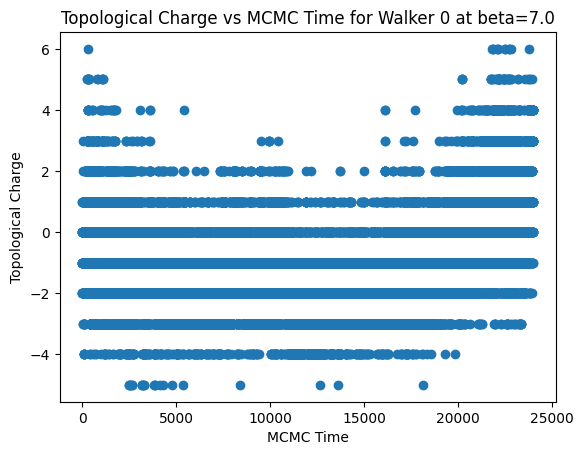

In [52]:
walker_id = 0
samples_per_walker = samples_ShapedForLattice[:, walker_id, :, :, :]

plt.scatter(range(len(samples_per_walker)), topo_charge(samples_per_walker))
plt.xlabel('MCMC Time')
plt.ylabel('Topological Charge')
plt.title(f'Topological Charge vs MCMC Time for Walker {walker_id} at beta={beta}')
plt.show()